In [28]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Libraries

In [29]:
import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist

In [30]:
!python -m spacy download es_dep_news_trf -q  #in english !python -m spacy download en_core_web_trf
import spacy

✔ Download and installation successful
You can now load the package via spacy.load('es_dep_news_trf')


In [31]:
import pandas as pd 
import numpy as np 

In [32]:
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

In [33]:
!pip install pyLDAvis -qq
!pip install -qq -U gensim

In [5]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook() # Visualise inside a notebook

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/botocore/httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext
/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Constants

In [35]:
DATA_PATH = '../DATA/news_125k-tokens-relevant.csv'

# Bespoke Functions

# Import data

In [38]:
df = pd.read_csv(DATA_PATH, index_col=0)
df.head()

,title,body,category,votes,clicks,comments,text,clean_text,token_lemma,noun_adj_verb,token_lemma_relevant
0,"Muere Toni Batllori, autor de la tira diaria d...",Toni Batllori Obiols ha fallecido esta noche e...,Culture,144,1100,11,"Muere Toni Batllori, autor de la tira diaria d...",Muere Toni Batllori autor de la tira diaria de...,morir Toni Batllori autor tira diario Vanguard...,morir autor tirar diario fallecer noche domici...,morir Toni Batllori autor tirar diario Vanguar...
1,La anarquía explicada a los niños por José A. ...,"En 1931 el maestro José Antonio Emmanuel, y me...",Culture,196,1800,109,La anarquía explicada a los niños por José A. ...,La anarquía explicada a los niños por José A E...,anarquía explicado niño José Emmanuel 1931 mae...,anarquía explicado niño maestro publicar panfl...,anarquía explicado niño José Emmanuel maestro ...
2,"Rhianan Rudd, la adolescente a la que el MI5 a...","Rhianan Rudd, una adolescente de 14 años que v...",Latest,330,6100,77,"Rhianan Rudd, la adolescente a la que el MI5 a...",Rhianan Rudd la adolescente a la que el MI5 ac...,Rhianan Rudd adolescente MI5 acusar terrorismo...,adolescente acusar terrorismo acabar suicidar ...,Rhianan Rudd adolescente MI5 acusar terrorismo...
3,Piden por burofax al obispo de Cartagena que r...,"La catedral de Murcia, la iglesia de El Salvad...",Politics,410,881,54,Piden por burofax al obispo de Cartagena que r...,Piden por burofax al obispo de Cartagena que r...,pedir burofax obispo Cartagena retirar símbolo...,pedir burofax obispo retirar símbolo franquist...,pedir burofax obispo Cartagena retirar símbolo...
4,Érase una vez... (1950),Érase una vez... (1950) dirigida por Josep Esc...,Culture,114,100,9,Érase una vez... (1950) Érase una vez... (1950...,Érase una vez 1950 Érase una vez 1950 dirigida...,érar 1950 era él 1950 dirigido Josep Escobar Z...,érar 1950 1950 dirigido película entero hija c...,érar 1950 ser 1950 dirigido Josep Escobar Zipi...


# Topic Modelling

### Tokenike the texts

In [41]:
%%time
nlp = spacy.load('es_dep_news_trf')

# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df['text']):
    proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

CPU times: user 1d 4h 24min 30s, sys: 46min 22s, total: 1d 5h 10min 52s
Wall time: 7h 27min 14s


In [42]:
df['tokens_for_topics'] = tokens
df['tokens_for_topics']

0         [morir, toni, batllori, autor, tira, diario, v...
1         [anarquía, explicado, niño, josé, emmanuel, ma...
2         [rhianan, rudd, adolescente, acusar, terrorism...
3         [pedir, burofax, obispo, cartagena, retirar, s...
4         [érase, érase, dirigido, josep, escobar, zipi,...
                                ...                        
123495    [juez, descubrir, traspaso, euros, aizóon, inf...
123496    [admiración, isaac, asimov, carl, sagan, histo...
123497    [hombre, libro, casa, eng, década, lawrence, t...
123498    [bbc, bronca, peaje, solar, españa, tv, públic...
123499    [multa, millonario, tesla, exagerar, autonomía...
Name: tokens_for_topics, Length: 123500, dtype: object

### Dictionary

In [44]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(tokens)


In [45]:
print(dictionary.token2id)

{'artista': 0, 'autor': 1, 'barcelona': 2, 'batllori': 3, 'colaborar': 4, 'diario': 5, 'dibujante': 6, 'domicilio': 7, 'década': 8, 'empezar': 9, 'entregar': 10, 'fallecer': 11, 'gana': 12, 'hora': 13, 'humor': 14, 'mantener': 15, 'momento': 16, 'morir': 17, 'multidisciplinar': 18, 'nacido': 19, 'noche': 20, 'obiols': 21, 'política': 22, 'publicar': 23, 'sección': 24, 'tira': 25, 'toni': 26, 'trabajar': 27, 'vanguardia': 28, 'anarquista': 29, 'anarquía': 30, 'antonio': 31, 'biblioteca': 32, 'emmanuel': 33, 'explicado': 34, 'explicar': 35, 'internacional': 36, 'josé': 37, 'maestro': 38, 'niño': 39, 'panfleto': 40, 'pensamiento': 41, 'sede': 42, 'utilizar': 43, 'ácrata': 44, 'acabar': 45, 'acto': 46, 'acusado': 47, 'acusar': 48, 'adolescente': 49, 'arrestar': 50, 'año': 51, 'bolsover': 52, 'británico': 53, 'ciudad': 54, 'cometer': 55, 'comisión': 56, 'conocido': 57, 'convertir': 58, 'cursar': 59, 'cárcel': 60, 'delito': 61, 'determinar': 62, 'enviar': 63, 'inteligencia': 64, 'investigaci

In [46]:
# I will filter out low-frequency and high-frequency tokens, also limit the vocabulary to a max of 10000 words
# No_below: Tokens that appear in less than 5 documents are filtered out.
# No_above: Tokens that appear in more than 50% of the total corpus are also removed as default.
# Keep_n: We limit ourselves to the top 1000 most frequent tokens (default is 100.000). Set to ‘None’ if you want to keep all.

dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=10000)

### Create a sparse vector with doc2bow

In [7]:
corpus = [dictionary.doc2bow(doc) for doc in df['tokens_for_topics']]

NameError: name 'df' is not defined

In [97]:
len(corpus)

123500

In [98]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 2),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 2),
 (23, 2),
 (24, 1),
 (25, 3)]

### LDA Model

#### Evaluating the coherence of the topics

C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity.  
This coherence measure retrieves cooccurrence counts for the given words using a sliding window and the window size 110. The counts are used to calculated the NPMI of every top word to every other top word, thus, resulting in a set of vectors—one for every top word. The one-set segmentation of the top words leads to the calculation of the similarity between every top word vector and the sum of all top word vectors. As similarity measure the cosinus is used. The coherence is the arithmetic mean of these similarities. (Note that this was the best coherence measure in our evalution.)

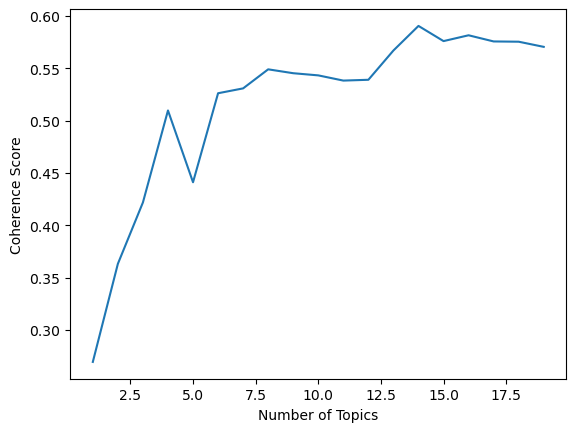

CPU times: user 41min 52s, sys: 6min 16s, total: 48min 8s
Wall time: 54min 36s


In [48]:
%%time
# Calculating the n_topics with the coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, 
                             id2word=dictionary, 
                             iterations=10, 
                             num_topics=i, 
                             workers=3, 
                             passes=10, 
                             random_state=100)
    cm = CoherenceModel(model=lda_model, 
                        texts=df['tokens_for_topics'], 
                        corpus=corpus, 
                        dictionary=dictionary, 
                        coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()



In [64]:
%%time
# Calculating the alpha with the coherence score using C_v:
alpha = []
alpha_score = []
alpha_values = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 'symmetric', 'asymmetric']
for i in alpha_values:
    lda_model = LdaMulticore(corpus=corpus, 
                             id2word=dictionary, 
                             num_topics=14, 
                             workers=3, 
                             random_state=100,
                             alpha=i)
    cm = CoherenceModel(model=lda_model, 
                        texts=df['tokens_for_topics'], 
                        corpus=corpus, 
                        dictionary=dictionary, 
                        coherence='c_v')
    alpha.append(i)
    alpha_score.append(cm.get_coherence())



CPU times: user 6min 39s, sys: 1min 1s, total: 7min 41s
Wall time: 10min 51s


In [66]:
alpha_results = pd.DataFrame(data=alpha_score, index=[alpha])
alpha_results


,0
0.01,0.443794
0.1,0.447371
0.3,0.448542
0.5,0.451715
0.7,0.433210
0.9,0.388053
1,0.357349
symmetric,0.448811
asymmetric,0.464462


In [72]:
%%time
# Calculating the eta with the coherence score using C_v:
eta = []
eta_score = []
eta_values = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 'symmetric']
for i in eta_values:
    lda_model = LdaMulticore(corpus=corpus, 
                             id2word=dictionary, 
                             num_topics=14, 
                             workers=3, 
                             random_state=100,
                             alpha='asymmetric',
                             eta=i)
    cm = CoherenceModel(model=lda_model, texts=df['tokens_for_topics'], corpus=corpus, dictionary=dictionary, coherence='c_v')
    eta.append(i)
    eta_score.append(cm.get_coherence())

CPU times: user 6min 3s, sys: 55.1 s, total: 6min 58s
Wall time: 9min 28s


In [73]:
eta_results = pd.DataFrame(data=eta_score, index=[eta])
eta_results

,0
0.01,0.461912
0.1,0.464031
0.3,0.460025
0.5,0.484073
0.7,0.488023
0.9,0.514882
1,0.520298
symmetric,0.468439


In [74]:
%%time
# Calculating the eta with the coherence score using C_v:
eta_2 = []
eta_score_2 = []
eta_values = [1, 2, 3]
for i in eta_values:
    lda_model = LdaMulticore(corpus=corpus, 
                             id2word=dictionary, 
                             num_topics=14, 
                             workers=3, 
                             random_state=100,
                             alpha='asymmetric',
                             eta=i)
    cm = CoherenceModel(model=lda_model, texts=df['tokens_for_topics'], corpus=corpus, dictionary=dictionary, coherence='c_v')
    eta_2.append(i)
    eta_score_2.append(cm.get_coherence())

CPU times: user 2min 19s, sys: 21.8 s, total: 2min 41s
Wall time: 3min 35s


In [75]:
eta_results_2 = pd.DataFrame(data=eta_score_2, index=[eta_2])
eta_results_2

,0
1,0.519140
2,0.494073
3,0.458266


### Fitting the final model

In [6]:
lda_model = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=10, 
                         num_topics=14, 
                         workers=3, 
                         passes=10,  
                         random_state=100,
                         alpha='asymmetric',
                         eta=1)

NameError: name 'corpus' is not defined

### Visualize the topics

In [77]:
lda_model.print_topics(-1) 


[(0,
  '0.012*"año" + 0.011*"historia" + 0.010*"mundo" + 0.006*"cosa" + 0.006*"tiempo" + 0.006*"vida" + 0.006*"película" + 0.005*"libro" + 0.005*"ver" + 0.005*"gente"'),
 (1,
  '0.023*"madrid" + 0.014*"social" + 0.011*"trabajo" + 0.011*"trabajador" + 0.010*"comunidad" + 0.010*"público" + 0.007*"red" + 0.006*"centro" + 0.006*"twitter" + 0.006*"denunciar"'),
 (2,
  '0.010*"año" + 0.009*"agua" + 0.009*"imagen" + 0.008*"tierra" + 0.008*"planeta" + 0.006*"espacial" + 0.006*"científico" + 0.006*"metro" + 0.005*"mundo" + 0.005*"mar"'),
 (3,
  '0.011*"web" + 0.011*"usuario" + 0.010*"google" + 0.010*"internet" + 0.008*"empresa" + 0.008*"sistema" + 0.008*"dato" + 0.007*"red" + 0.007*"compañía" + 0.006*"servicio"'),
 (4,
  '0.013*"josé" + 0.012*"periodista" + 0.011*"juan" + 0.010*"carlos" + 0.010*"rey" + 0.007*"españa" + 0.006*"director" + 0.006*"gonzález" + 0.006*"medio" + 0.006*"español"'),
 (5,
  '0.052*"año" + 0.025*"mujer" + 0.016*"niño" + 0.016*"hombre" + 0.015*"morir" + 0.014*"joven" + 0.0

In [82]:
df['text'][0] # this text...


'Muere Toni Batllori, autor de la tira diaria de La Vanguardia Toni Batllori Obiols ha fallecido esta noche en su domicilio de Teià, unas horas después de entregar su tira diaria, que publicaba en la sección de Política de La Vanguardia desde 1994.  El dibujante y artista multidisciplinar ha mantenido el buen humor y las ganas de trabajar hasta el último momento. Nacido en Barcelona en 1951, empezó a colaborar con La Vanguardia hace más de tres décadas.'

In [83]:
# ... belongs to these topics
lda_model[corpus][0]



[(0, 0.5545393),
 (4, 0.09537807),
 (5, 0.11342094),
 (6, 0.10743894),
 (10, 0.11081482)]

### Display the topics

In [84]:
%%time
lda_display = pyLDAvis.gensim_models.prepare(lda_model, 
                                             corpus, 
                                             dictionary, 
                                             sort_topics=False)
pyLDAvis.display(lda_display)


/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: 

/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__v

CPU times: user 40.7 s, sys: 742 ms, total: 41.5 s
Wall time: 55.9 s


### Save the display in a html format

In [85]:
pyLDAvis.save_html(lda_display, '../lda_display.html')

### Add topics to the dataframe

In [86]:
df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df['text']))]


In [87]:
df.head()

,title,body,category,votes,clicks,comments,text,clean_text,token_lemma,noun_adj_verb,token_lemma_relevant,tokens_for_topics,topic
0,"Muere Toni Batllori, autor de la tira diaria d...",Toni Batllori Obiols ha fallecido esta noche e...,Culture,144,1100,11,"Muere Toni Batllori, autor de la tira diaria d...",Muere Toni Batllori autor de la tira diaria de...,morir Toni Batllori autor tira diario Vanguard...,morir autor tirar diario fallecer noche domici...,morir Toni Batllori autor tirar diario Vanguar...,"[morir, toni, batllori, autor, tira, diario, v...",0
1,La anarquía explicada a los niños por José A. ...,"En 1931 el maestro José Antonio Emmanuel, y me...",Culture,196,1800,109,La anarquía explicada a los niños por José A. ...,La anarquía explicada a los niños por José A E...,anarquía explicado niño José Emmanuel 1931 mae...,anarquía explicado niño maestro publicar panfl...,anarquía explicado niño José Emmanuel maestro ...,"[anarquía, explicado, niño, josé, emmanuel, ma...",0
2,"Rhianan Rudd, la adolescente a la que el MI5 a...","Rhianan Rudd, una adolescente de 14 años que v...",Latest,330,6100,77,"Rhianan Rudd, la adolescente a la que el MI5 a...",Rhianan Rudd la adolescente a la que el MI5 ac...,Rhianan Rudd adolescente MI5 acusar terrorismo...,adolescente acusar terrorismo acabar suicidar ...,Rhianan Rudd adolescente MI5 acusar terrorismo...,"[rhianan, rudd, adolescente, acusar, terrorism...",1
3,Piden por burofax al obispo de Cartagena que r...,"La catedral de Murcia, la iglesia de El Salvad...",Politics,410,881,54,Piden por burofax al obispo de Cartagena que r...,Piden por burofax al obispo de Cartagena que r...,pedir burofax obispo Cartagena retirar símbolo...,pedir burofax obispo retirar símbolo franquist...,pedir burofax obispo Cartagena retirar símbolo...,"[pedir, burofax, obispo, cartagena, retirar, s...",1
4,Érase una vez... (1950),Érase una vez... (1950) dirigida por Josep Esc...,Culture,114,100,9,Érase una vez... (1950) Érase una vez... (1950...,Érase una vez 1950 Érase una vez 1950 dirigida...,érar 1950 era él 1950 dirigido Josep Escobar Z...,érar 1950 1950 dirigido película entero hija c...,érar 1950 ser 1950 dirigido Josep Escobar Zipi...,"[érase, érase, dirigido, josep, escobar, zipi,...",0


In [99]:
label_dicc = {0:'entertainment', 
              1:'labor', 
              2:'environment', 
              3:'technology', 
              4:'spanish monarchy',
              5:'violence', 
              6:'spanish politics', 
              7:'energy crisis', 
              8:'healthcare', 
              9: 'war', 
              10:'police', 
              11:'spanish history',
              12:'justice',
              13:'economic crisis'}

df['topic_name'] = df['topic'].map(label_dicc)



In [100]:
df.head()

,title,body,category,votes,clicks,comments,text,clean_text,token_lemma,noun_adj_verb,token_lemma_relevant,tokens_for_topics,topic,topic_name
0,"Muere Toni Batllori, autor de la tira diaria d...",Toni Batllori Obiols ha fallecido esta noche e...,Culture,144,1100,11,"Muere Toni Batllori, autor de la tira diaria d...",Muere Toni Batllori autor de la tira diaria de...,morir Toni Batllori autor tira diario Vanguard...,morir autor tirar diario fallecer noche domici...,morir Toni Batllori autor tirar diario Vanguar...,"[morir, toni, batllori, autor, tira, diario, v...",0,entertainment
1,La anarquía explicada a los niños por José A. ...,"En 1931 el maestro José Antonio Emmanuel, y me...",Culture,196,1800,109,La anarquía explicada a los niños por José A. ...,La anarquía explicada a los niños por José A E...,anarquía explicado niño José Emmanuel 1931 mae...,anarquía explicado niño maestro publicar panfl...,anarquía explicado niño José Emmanuel maestro ...,"[anarquía, explicado, niño, josé, emmanuel, ma...",0,entertainment
2,"Rhianan Rudd, la adolescente a la que el MI5 a...","Rhianan Rudd, una adolescente de 14 años que v...",Latest,330,6100,77,"Rhianan Rudd, la adolescente a la que el MI5 a...",Rhianan Rudd la adolescente a la que el MI5 ac...,Rhianan Rudd adolescente MI5 acusar terrorismo...,adolescente acusar terrorismo acabar suicidar ...,Rhianan Rudd adolescente MI5 acusar terrorismo...,"[rhianan, rudd, adolescente, acusar, terrorism...",1,labor
3,Piden por burofax al obispo de Cartagena que r...,"La catedral de Murcia, la iglesia de El Salvad...",Politics,410,881,54,Piden por burofax al obispo de Cartagena que r...,Piden por burofax al obispo de Cartagena que r...,pedir burofax obispo Cartagena retirar símbolo...,pedir burofax obispo retirar símbolo franquist...,pedir burofax obispo Cartagena retirar símbolo...,"[pedir, burofax, obispo, cartagena, retirar, s...",1,labor
4,Érase una vez... (1950),Érase una vez... (1950) dirigida por Josep Esc...,Culture,114,100,9,Érase una vez... (1950) Érase una vez... (1950...,Érase una vez 1950 Érase una vez 1950 dirigida...,érar 1950 era él 1950 dirigido Josep Escobar Z...,érar 1950 1950 dirigido película entero hija c...,érar 1950 ser 1950 dirigido Josep Escobar Zipi...,"[érase, érase, dirigido, josep, escobar, zipi,...",0,entertainment


### Checking

In [91]:
df[['topic_name', 'topic']].value_counts(normalize=True)



topic_name        topic
entertainment     0        0.495457
labor             1        0.177984
environment       2        0.091077
technology        3        0.056032
spanish monarchy  4        0.054040
violence          5        0.041879
spanish politics  6        0.030494
energy crisis     7        0.018130
healthcare        8        0.011150
war               9        0.009417
police            10       0.005506
spanish history   11       0.003320
justice           12       0.002915
economic crisis   13       0.002599
dtype: float64

In [92]:
df[df['topic']==0]

,title,body,category,votes,clicks,comments,text,clean_text,token_lemma,noun_adj_verb,token_lemma_relevant,tokens_for_topics,topic,topic_name
0,"Muere Toni Batllori, autor de la tira diaria d...",Toni Batllori Obiols ha fallecido esta noche e...,Culture,144,1100,11,"Muere Toni Batllori, autor de la tira diaria d...",Muere Toni Batllori autor de la tira diaria de...,morir Toni Batllori autor tira diario Vanguard...,morir autor tirar diario fallecer noche domici...,morir Toni Batllori autor tirar diario Vanguar...,"[morir, toni, batllori, autor, tira, diario, v...",0,entertainment
1,La anarquía explicada a los niños por José A. ...,"En 1931 el maestro José Antonio Emmanuel, y me...",Culture,196,1800,109,La anarquía explicada a los niños por José A. ...,La anarquía explicada a los niños por José A E...,anarquía explicado niño José Emmanuel 1931 mae...,anarquía explicado niño maestro publicar panfl...,anarquía explicado niño José Emmanuel maestro ...,"[anarquía, explicado, niño, josé, emmanuel, ma...",0,entertainment
4,Érase una vez... (1950),Érase una vez... (1950) dirigida por Josep Esc...,Culture,114,100,9,Érase una vez... (1950) Érase una vez... (1950...,Érase una vez 1950 Érase una vez 1950 dirigida...,érar 1950 era él 1950 dirigido Josep Escobar Z...,érar 1950 1950 dirigido película entero hija c...,érar 1950 ser 1950 dirigido Josep Escobar Zipi...,"[érase, érase, dirigido, josep, escobar, zipi,...",0,entertainment
5,En la noche de Reyes todos hacemos una cena má...,En la noche de Reyes todos hacemos una cena má...,Latest,419,7600,105,En la noche de Reyes todos hacemos una cena má...,En la noche de Reyes todos hacemos una cena má...,noche Reyes cena especial residencia público C...,noche cena especial residencia público noche c...,noche Reyes cena especial residencia público C...,"[noche, reyes, cena, especial, residencia, púb...",0,entertainment
6,"La única iglesia ibérica de mármol es suya, qu...",Hay pocas iglesias construidas en mármol en el...,Culture,161,5400,36,"La única iglesia ibérica de mármol es suya, qu...",La única iglesia ibérica de mármol es suya que...,único iglesia ibérico mármol querido señora ig...,único iglesia ibérico mármol querido señora ig...,único iglesia ibérico mármol querido señora ig...,"[único, iglesia, ibérico, mármol, querido, señ...",0,entertainment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123489,La estafa de los certificados energéticos de G...,Hace unas semanas nos contactaron de Groupon p...,Latest,1100,10500,72,La estafa de los certificados energéticos de G...,La estafa de los certificados energéticos de G...,estafa certificado energético Groupon semana c...,estafa certificado energético semana contactar...,estafa certificado energético Groupon semana c...,"[estafa, certificado, energético, groupon, sem...",0,entertainment
123491,"Una presentadora turca, despedida por lucir un...",La popular presentadora y actriz turca Gözde K...,Latest,586,2000,86,"Una presentadora turca, despedida por lucir un...",Una presentadora turca despedida por lucir un ...,presentadora turco despedido lucir escote exce...,presentadora turco despedido lucir escote exce...,presentadora turco despedido lucir escote exce...,"[presentadora, turco, despedido, lucir, escote...",0,entertainment
123496,La admiración de Isaac Asimov por Carl Sagan,La historia nos ha relatado muchas historias a...,Latest,498,500,130,La admiración de Isaac Asimov por Carl Sagan L...,La admiración de Isaac Asimov por Carl Sagan L...,admiración Isaac Asimov Carl Sagan historia re...,admiración historia relatar historia admiració...,admiración Isaac Asimov Carl Sagan historia re...,"[admiración, isaac, asimov, carl, sagan, histo...",0,entertainment
123497,El hombre con 59.000 libros... en su casa (ENG),"En la década de 1920, Lawrence L. Thomas, un d...",Latest,270,9400,68,El hombre con 59.000 libros... en su casa (ENG...,El hombre con 59000 libros en su casa ENG En l...,hombre 59000 libro casa ENG década 1920 Lawren...,hombre 

### Basic Linguistic statistics 

Basic linguistic statistics is also valuable for feature engineering on this set. We may create additional representative characteristics such as:

- count_sent (how many sentences in every cleaned paragraph);
- num_count (how many numbers occur in every cleaned paragraph);
- count_words (how many words contains every cleaned paragraph).

In [ ]:
df['count_sent'] = df.remove_stop_words.apply(lambda series: 1 if series.count('zdot') == 0 else series.count('zdot'))
df['num_count'] = df.remove_stop_words.apply(lambda series: series.count('znum'))
df['count_words'] = df.remove_stop_words.apply(lambda series: len(nlp(series)))

# Save File

In [93]:
df.to_csv('../DATA/news_125k-tokens-relevant-with_topic.csv')